
**Aim**: Use train.csv data and predict liklihood of outcome variable being equal to 1 in test.csv

Submitted by

Lata

02/18/2020

Approach: I followed the following steps
* Data Exploration : Identify missing value, outliers
* Data Processing: Encode categorical variable, Deal with Missing values
* Cross Validation: Split data into train and test datasets to prevent overfitting and test model performance
* Standardise the data
* Use ML models to predict the outcome variable
* Check performace using AUC -> 0.6
* Upsample to improve model AUC -> 0.87
* Use best model to predict output on test dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [2]:
data  = pd.read_csv('data/train.csv')
data.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [3]:
data.tail()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
9995,41,0.004225,desktop,M,0,64489,2,3,8,0
9996,50,0.004751,other,F,0,88643,1,3,0,0
9997,60,0.003804,other,M,0,87870,2,2,9,0
9998,18,0.003838,laptop,M,0,56468,2,2,0,0
9999,33,0.005250,iPhone,NaN,0,59935,2,1,6,0


### Data Exploration

In [4]:
set(data['outcome'])

{0, 1}

* Its a Binary classification problem

In [5]:
data['outcome'].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

* It's an **imbalanced** classification problem

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [9]:
cat_data = data.select_dtypes(include=['object']).copy()

In [10]:
# check for missing info
cat_data.isna().sum()

device_type      0
gender         269
dtype: int64

 we need to handle the 269 missing cases in the "gender" feature

In [11]:
## check for outliers/garbage values
data.describe()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000
mean,37.991800,0.004666,0.497500,58004.335800,1.497000,2.00220,5.406800,0.0982
std,13.038203,0.000838,0.500019,17330.778355,0.500016,0.81784,5.046014,0.2976
min,16.000000,0.003171,0.000000,16241.000000,1.000000,1.00000,0.000000,0.0000
25%,27.000000,0.003995,0.000000,45533.500000,1.000000,1.00000,1.000000,0.0000
50%,38.000000,0.004625,0.000000,58053.500000,1.000000,2.00000,4.000000,0.0000
75%,49.000000,0.005164,1.000000,70235.250000,2.000000,3.00000,8.000000,0.0000
max,60.000000,0.007082,1.000000,99956.000000,2.000000,3.00000,22.000000,1.0000


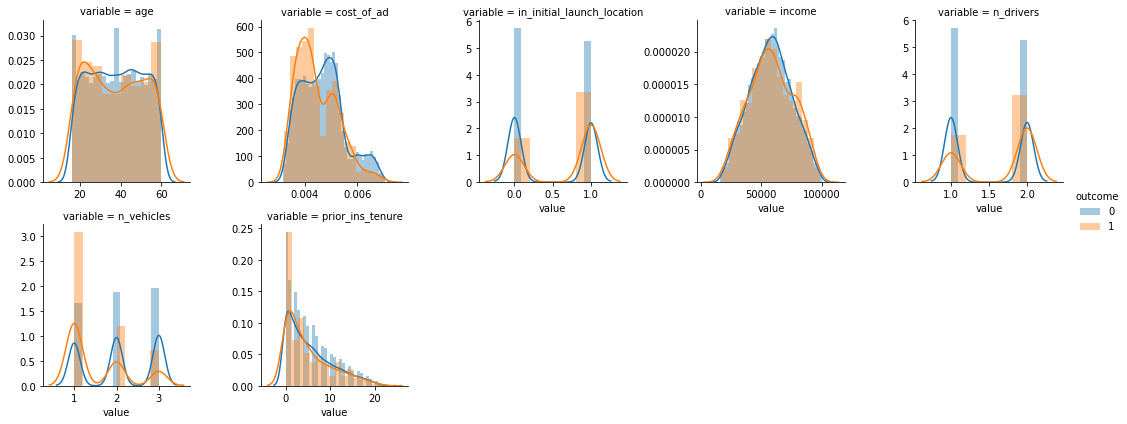

In [12]:
## EDA
## Plotting data
output = 'outcome'

cols = [ f for f in data.columns if data.dtypes[ f ] != "object"]
cols.remove( output )

f = pd.melt( data, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

In [13]:
data['in_initial_launch_location'].unique()

array([0, 1])

* Possibly no outliers in the numeric variables

In [17]:
## Look at different categorical vs numeric features
data.dtypes

age                             int64
cost_of_ad                    float64
device_type                    object
gender                           int8
in_initial_launch_location      int64
income                          int64
n_drivers                       int64
n_vehicles                      int64
prior_ins_tenure                int64
outcome                         int64
dtype: object

In [15]:
data.nunique()

age                             45
cost_of_ad                    9984
device_type                      5
gender                           2
in_initial_launch_location       2
income                        9268
n_drivers                        2
n_vehicles                       3
prior_ins_tenure                23
outcome                          2
dtype: int64

Categorical variables are:
* device_type                      
* gender                           

## Data Preprocessing
### Encode Categorical variables


In [16]:
## Encode categorical variables
data['gender'] = data['gender'].astype('category')
data['gender'] = data['gender'].cat.codes
print(data['gender'].value_counts())

# categorical variables - One hot encode
cols = data.dtypes
cat_var = 'device_type'
X = np.array(data[cat_var]).reshape(-1, 1)

 0    4970
 1    4761
-1     269
Name: gender, dtype: int64


In [18]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
X_2 = le.fit_transform(X)

In [19]:
le.get_feature_names()

array(['x0_Android', 'x0_desktop', 'x0_iPhone', 'x0_laptop', 'x0_other'],
      dtype=object)

In [20]:
import scipy.sparse
#mat = scipy.sparse.eye(3)
cat_features = pd.DataFrame.sparse.from_spmatrix(X_2)

In [21]:
cat_features.columns = ['x0_Android', 'x0_desktop', 'x0_iPhone', 'x0_laptop', 'x0_other']
cat_features.tail()

,x0_Android,x0_desktop,x0_iPhone,x0_laptop,x0_other
9995,0.0,1.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,1.0
9997,0.0,0.0,0.0,0.0,1.0
9998,0.0,0.0,0.0,1.0,0.0
9999,0.0,0.0,1.0,0.0,0.0


In [22]:
cols = data.dtypes
print(cols)

age                             int64
cost_of_ad                    float64
device_type                    object
gender                           int8
in_initial_launch_location      int64
income                          int64
n_drivers                       int64
n_vehicles                      int64
prior_ins_tenure                int64
outcome                         int64
dtype: object


In [23]:
numeric_cols = list(cols[cols != 'object'].index)
numeric_features = data[numeric_cols]
all_data = pd.concat([numeric_features, cat_features], axis = 1)

In [24]:
all_data.head()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,x0_Android,x0_desktop,x0_iPhone,x0_laptop,x0_other
0,56,0.005737,1,0,62717,2,1,4,0,0.0,0.0,1.0,0.0,0.0
1,50,0.004733,0,0,64328,2,3,2,0,0.0,1.0,0.0,0.0,0.0
2,54,0.004129,1,0,83439,1,3,7,0,0.0,0.0,0.0,1.0,0.0
3,16,0.005117,0,0,30110,2,3,0,0,1.0,0.0,0.0,0.0,0.0
4,37,0.003635,1,0,76565,2,1,5,0,0.0,1.0,0.0,0.0,0.0


In [25]:
all_data.tail()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,x0_Android,x0_desktop,x0_iPhone,x0_laptop,x0_other
9995,41,0.004225,1,0,64489,2,3,8,0,0.0,1.0,0.0,0.0,0.0
9996,50,0.004751,0,0,88643,1,3,0,0,0.0,0.0,0.0,0.0,1.0
9997,60,0.003804,1,0,87870,2,2,9,0,0.0,0.0,0.0,0.0,1.0
9998,18,0.003838,1,0,56468,2,2,0,0,0.0,0.0,0.0,1.0,0.0
9999,33,0.005250,-1,0,59935,2,1,6,0,0.0,0.0,1.0,0.0,0.0


In [26]:
all_data.shape

(10000, 14)

In [27]:
all_data.isna().sum()

age                           0.0
cost_of_ad                    0.0
gender                        0.0
in_initial_launch_location    0.0
income                        0.0
n_drivers                     0.0
n_vehicles                    0.0
prior_ins_tenure              0.0
outcome                       0.0
x0_Android                    0.0
x0_desktop                    0.0
x0_iPhone                     0.0
x0_laptop                     0.0
x0_other                      0.0
dtype: float64

### Remove rows with missing gender information

In [29]:
# remove rows with gender = -1
all_data = all_data[all_data.gender != -1]
print(all_data.shape)

(9731, 14)


An alternative to this approach could be using prediction model to impute missing data. 

#### Cross Validation

In [53]:
output = 'outcome'
cols = all_data.dtypes
features =  list(cols[cols != output].index)
features.remove(output)
X = all_data[features].values    
y = all_data[ output ].values

# Split the data to train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

### Standardise data set
Refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation of one (unit variance).

In [54]:
from sklearn.preprocessing import StandardScaler
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

## Machine Learning

In [55]:
## ML Model
#-------------- 
# Logistic Regression
#--------------
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit( X_train, y_train )
y_pred = classifier.predict( X_test )


from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred,pos_label=1)
metrics.auc(fpr, tpr)

/Users/charu/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5550244888072267

In [59]:
#-------------- 
# Random Forest
#--------------
from sklearn.ensemble import RandomForestClassifier
classifier1 = RandomForestClassifier(n_estimators = 12)
classifier1.fit( X_train, y_train )
y_pred = classifier1.predict( X_test )

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred,pos_label=1)
print(metrics.auc(fpr, tpr))

0.611809572199148


In [34]:
#-------------- 
# kernel SVM 
#--------------
from sklearn.svm import SVC
classifier3 = SVC(kernel="rbf")
classifier3.fit( X_train, y_train )
y_pred = classifier3.predict( X_test )

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred,pos_label=1)
print(metrics.auc(fpr, tpr))

0.5663852420120216


In [35]:
## Tree based model : boosting model

## Working around the unbalanced dataset
Since none of the models perform well due to unbalenced dataset, I oversample the minority class. We know that there are 9018 0's and 982 1's. We upsample 1's to 2000.

In [37]:
from sklearn.utils import resample
all_data_majority = all_data[all_data.outcome==0]
all_data_minority = all_data[all_data.outcome==1]

# Upsample minority class
all_data_minority_upsampled = resample(all_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
all_data_upsampled = pd.concat([all_data_majority, all_data_minority_upsampled])
 
# Display new class counts
all_data_upsampled.outcome.value_counts()

0    8758
1    2000
Name: outcome, dtype: int64

In [38]:
all_data_upsampled.isna().sum()

age                           0.0
cost_of_ad                    0.0
gender                        0.0
in_initial_launch_location    0.0
income                        0.0
n_drivers                     0.0
n_vehicles                    0.0
prior_ins_tenure              0.0
outcome                       0.0
x0_Android                    0.0
x0_desktop                    0.0
x0_iPhone                     0.0
x0_laptop                     0.0
x0_other                      0.0
dtype: float64

### Training model on new resampled data

In [39]:
output = 'outcome'
cols = all_data_upsampled.dtypes
features =  list(cols[cols != output].index)
features.remove(output)
X = all_data_upsampled[features].values    
y = all_data_upsampled[ output ].values

# Split the data to train/test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

### Standardise Dataset
scX = StandardScaler()
X_train = scX.fit_transform( X_train )
X_test = scX.transform( X_test )

#-------------- 
# Random Forest
#--------------
from sklearn.ensemble import RandomForestClassifier
classifier11 = RandomForestClassifier(n_estimators = 10)
classifier11.fit( X_train, y_train )
y_pred = classifier11.predict( X_test )

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred,pos_label=1)
print(metrics.auc(fpr, tpr))

0.8718502599550987


This works with AUC 0.87. I will use the *classifier11* model to predict the test dateset

## Test Data

In [40]:
data_test = pd.read_csv('data/test.csv')
print(data_test.shape)
data_test.head()

(10000, 9)


,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
0,34,0.005134,Android,F,1,40376,1,3,7
1,53,0.005223,desktop,F,1,84511,1,1,11
2,46,0.004939,laptop,F,0,79322,1,1,4
3,36,0.004924,Android,F,0,63295,1,2,0
4,28,0.005146,other,F,1,36170,1,3,3


#### Applying data Processing steps to the data_test

In [41]:
data_test.isna().sum()

age                             0
cost_of_ad                      0
device_type                     0
gender                        249
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
dtype: int64

In [42]:
data.describe()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000
mean,37.991800,0.004666,0.449200,0.497500,58004.335800,1.497000,2.00220,5.406800,0.0982
std,13.038203,0.000838,0.548862,0.500019,17330.778355,0.500016,0.81784,5.046014,0.2976
min,16.000000,0.003171,-1.000000,0.000000,16241.000000,1.000000,1.00000,0.000000,0.0000
25%,27.000000,0.003995,0.000000,0.000000,45533.500000,1.000000,1.00000,1.000000,0.0000
50%,38.000000,0.004625,0.000000,0.000000,58053.500000,1.000000,2.00000,4.000000,0.0000
75%,49.000000,0.005164,1.000000,1.000000,70235.250000,2.000000,3.00000,8.000000,0.0000
max,60.000000,0.007082,1.000000,1.000000,99956.000000,2.000000,3.00000,22.000000,1.0000


In [47]:
data_test.describe()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,38.029200,0.004668,0.459600,0.500900,58232.104800,1.486300,2.009100,5.319800
std,12.896921,0.000836,0.546075,0.500024,17318.192722,0.499837,0.817242,5.019487
min,16.000000,0.003173,-1.000000,0.000000,16124.000000,1.000000,1.000000,0.000000
25%,27.000000,0.004000,0.000000,0.000000,45575.250000,1.000000,1.000000,1.000000
50%,38.000000,0.004609,0.000000,1.000000,58271.000000,1.000000,2.000000,4.000000
75%,49.000000,0.005175,1.000000,1.000000,70438.750000,2.000000,3.000000,8.000000
max,60.000000,0.007049,1.000000,1.000000,99916.000000,2.000000,3.000000,22.000000


Training data and Test data have  similar distributions. Hence, the model *classifier11* should work well for the test_data.

In [43]:
## Encode
## Encode categorical variables
data_test['gender'] = data_test['gender'].astype('category')
data_test['gender'] = data_test['gender'].cat.codes
print(data_test['gender'].value_counts())

# categorical variables - One hot encode
cols = data_test.dtypes
cat_var = 'device_type'
Xt = np.array(data_test[cat_var]).reshape(-1, 1)

 0    4906
 1    4845
-1     249
Name: gender, dtype: int64


In [44]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        10000 non-null int8
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
dtypes: float64(1), int64(6), int8(1), object(1)
memory usage: 634.9+ KB


In [45]:
Xt_2 = le.fit_transform(Xt)
numeric_cols = list(cols[cols != 'object'].index)
numeric_features = data_test[numeric_cols]
all_data_test = pd.concat([numeric_features, cat_features], axis = 1)
all_data_test.head()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,x0_Android,x0_desktop,x0_iPhone,x0_laptop,x0_other
0,34,0.005134,0,1,40376,1,3,7,0.0,0.0,1.0,0.0,0.0
1,53,0.005223,0,1,84511,1,1,11,0.0,1.0,0.0,0.0,0.0
2,46,0.004939,0,0,79322,1,1,4,0.0,0.0,0.0,1.0,0.0
3,36,0.004924,0,0,63295,1,2,0,1.0,0.0,0.0,0.0,0.0
4,28,0.005146,0,1,36170,1,3,3,0.0,1.0,0.0,0.0,0.0


In [46]:
all_data_test = all_data_test[all_data_test.gender != -1]
print(all_data_test.shape)
print(all_data_test['gender'].value_counts())

(9751, 13)
0    4906
1    4845
Name: gender, dtype: int64


## Predicting using *classifier11*

In [50]:
classifier11.predict(all_data_test)[0:5]

array([0, 0, 0, 0, 0])